# TRAVEL CLAIM : WHO IS GOING TO CLAIM ?

# 1 Business Problem

## 1.1 Context 
Dalam memulai awal tahun sebuah perusahaan asuransi  asal Singapura ingin menyusun rencana anggaran keuangan untuk setahun kedepan. Dari data customer yang melakukan dan tidak melakukan claim sebelumnya, perushaan ingin memprediksi siapa saja customer yang akan melakukan claim kedepannya agar perusahaan membuat renca keuangan yang baik serta dapat mengalokasikan keuangan untuk diputar pada bisnis lainnya.


## 1.2 Problem Statement
Perusahaan dalam membuat rencana anggaran, ingin memprediksi pada produk asuransi perjalanan mereka manakah customer yang akan melakukan claim serta yang tidak akan melakukan claim, agar perusahaan dapat menyiapkan dana tidak bergerak yang dibutuhkan, agar perushaan tetap memiliki dana yang cukup, apabila sewaktu-waktu customer melakukan claim, dan dana lainnya tetap bisa digunakan untuk mengembangkan bisnis lainnya.


## 1.3 Goals
Dengan bantuan machine learning kita ingin memprediksi customer mana saja yang akan melakukan claim dan mana yang tidak melakukan claim, dari hasil yang didapatkan kita akan memberikan perkiraan dana tidak bergerak yang akan dibutuhkan perusahaan untuk tetap diam dan tidak dipergunakan untuk bisnis lainnya, sehingga perusahaan tetap bisa mencairkan dana claim customer dan membuat citra perusahaan tetap baik serta dapat mengalokasikan dana yang diperlukan untuk mengembangkan bisnis lainnya.

## 1.4 Analytic Approach
Dari feature-feature yang telah dipilih nanti, kita akan membuat model klafikasi untuk memprediksi customer mana yang berpotensi untuk melakukan claim dan customer mana yang tidak akan melakukan claim asuransi.

## 1.5 Matrix Evaluation 

Target :                 
* 1 : Customer Melakukan Claim                 
* 0 : Customer Tidak Melakukan Claim            

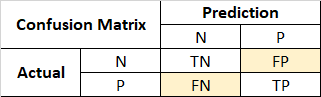

* TP = dapat memprediksi customer yang berpotensi untuk melakukan claim
* TN = dapat memprediksi customer yang tidak akan melakukan claim
* FP = salah memprediksi customer yang berpotensi melakukan claim asuransi tetapi kenyataanya tidak melakukan claim asuransi   
    cons : Terjadinya idle cash yang mengakibatkan tidak produktifnya perencanaan keuangan perusahaan
* FN = salah memprediksi customer yang tidak akan melakukan claim asuransi tetapi kenyataanya customer melakukan claim asuransi <br>
    cons : Perusahaan memerlukan dana yang tidak dipersiapkan sebelumnya yang mengakibatkan claim jadi lebih lambat dan reputasi perusahaan menurun
    

Berdasarkan problem statement disini kita tidak ingin salah dalam memprediksi customer mana yang akan melakukan claim dan tidak, dari konsekuensi yang diberikan disini kita ingin menekan nilai False Positive (FP) dan False Negative (FN). agar memastikan prediksi yang kita lakukan sesuai. dari data yang diberikan, kita melihat bahwa data yang diberikan merupakan data imbalance. oleh karena itu matrix evaluasi yang kita pilih ialah yang memiliki nilai F1 yang paling tinggi.

# 2. Simple Explanatory Data Analysis

In [109]:
# Library
import pandas as pd
import numpy as np

import missingno
from scipy.stats import chi2_contingency

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import fbeta_score, make_scorer, accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import precision_score, roc_curve, roc_auc_score, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# saving/loading model
import pickle

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

## 2.1 DATA UNDERSTANDING

In [2]:
# Load Dataset
travel = pd.read_csv("data_travel_insurance.csv")
travel.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [3]:
# ingin mengetahui jumlah baris dan kolom dataset
travel.shape

(44328, 11)

### ATRIBUT
- Target:  
    * `Claim`                : Apakah customer melakukan claim atau tidak
    
- Feature: 
    * `Agency`               : Nama travel agensi    
    * `Agency Type`          : Tipe travel agensi                
    * `Distribution Channel` : Cara agensi mendistribusikan produknya       
    * `Poduct Name`          : Nama produk asuransi           
    * `Gender`               : Jenis kelamin dari pemegang asuransi    
    * `Duration`             : Durasi perjalanan produk yang satuannya adalah Hari           
    * `Destination`          : Tujuan perjalanan produk             
    * `Net Sales`            : Besaran harga penjualan produk asuransi             
    * `Commission`           : Besaran komisi yang didapat oleh travel agensi             
    * `Age`                  : Usia dari pemegang asuransi     

In [4]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [5]:
# cek keseimbangan data pada target
display (travel['Claim'].value_counts(),  # isi data pada variabel claim
         travel['Claim'].value_counts()/travel.shape[0]*100) # persentase isi data pada variabel claim

No     43651
Yes      677
Name: Claim, dtype: int64

No     98.472749
Yes     1.527251
Name: Claim, dtype: float64

<AxesSubplot:xlabel='Claim', ylabel='count'>

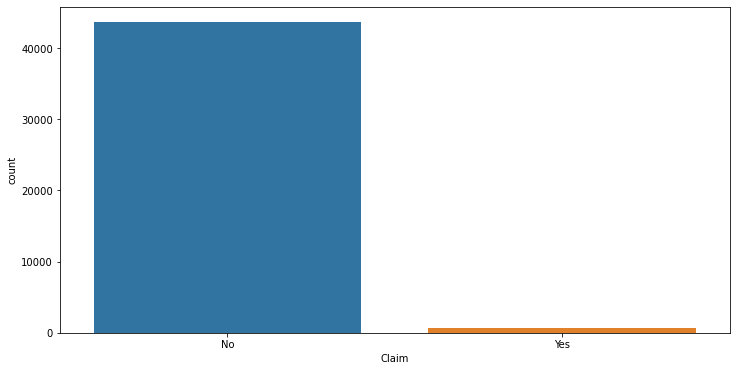

In [6]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Claim', data=travel,
             order=travel['Claim'].value_counts().index)

In [7]:
# mengecek missing value pada dataset 
travel.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Age                         0
Claim                       0
dtype: int64

In [8]:
#cek data duplikat
travel.duplicated().sum()

4667

In [9]:
display(travel.describe(), travel.describe(include='O').T)

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


,count,unique,top,freq
Agency,44328,16,EPX,24656
Agency Type,44328,2,Travel Agency,32113
Distribution Channel,44328,2,Online,43572
Product Name,44328,26,Cancellation Plan,12979
Gender,12681,2,M,6504
Destination,44328,138,SINGAPORE,9267
Claim,44328,2,No,43651


Dari dataset terlihat bahwa:
* Dataset memiliki 44328 baris data serta 11 kolom     
* Beberapa kolom yang bertipe numerik hanya Duration, Net Sales, Commision (in value), Age, selebihnya memiliki tipe kolom objective sehingga masih harus dilakukam preprocessing agar bisa dimasukkan kedalam pemodelan    
* Target juga memiliki proporsi imbalance yang sangat tinggi yakni 98.5 % : 1.5 %
* Dataset juga memiliki missing value yang cukup tinggi pada kolom Gender yang akan di drop saja karena tidak diperlukan pada pemodelan kali ini    
* Pada dataset juga memiliki data duplikat, kita akan mendrop data duplikat dalam mengatasinya
* Pada kolom Duration memiliki data aneh yakni durasi -1 yang dimana tidak mungkin juga melakukan perjalanan sehingga nanti akan di drop baris yang bernilai -1
* Pada kolom net sales terdapat data sales yang bernilai negatif, disini masih masuk akal karena penjualan mungkin mengalami kerugian    
* Pada kolom Age ada yang bernilai 0, disini juga masih masuk akal kerena yang bernilai 0 mungkin yang dimaksud adalah bayi yang belom genap 1 tahun, dan ada juga yang berusia 118 juga masih masuk akal menurut saya, sehingga akan dibiarkan saja.

## 2.2 Data Cleaning

In [10]:
# kita akan mendrop semua kolom gender
travel.drop(columns=['Gender'], axis=1, inplace=True)

In [11]:
# kita akan mendrop data tidak normal pada kolom duration
not_normal=travel[travel['Duration']<0].index
travel.drop(index=not_normal,inplace=True)

In [12]:
# kita akan mendrop data duplicate
travel.drop_duplicates(inplace=True)

## 2.3 Data After Cleaning

In [13]:
travel.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28,No


In [14]:
travel.shape

(39322, 10)

In [15]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39322 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                39322 non-null  object 
 1   Agency Type           39322 non-null  object 
 2   Distribution Channel  39322 non-null  object 
 3   Product Name          39322 non-null  object 
 4   Duration              39322 non-null  int64  
 5   Destination           39322 non-null  object 
 6   Net Sales             39322 non-null  float64
 7   Commision (in value)  39322 non-null  float64
 8   Age                   39322 non-null  int64  
 9   Claim                 39322 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 3.3+ MB


In [16]:
travel.isna().sum()

Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Age                     0
Claim                   0
dtype: int64

In [17]:
display(travel.describe(), travel.describe(include='O').T)

,Duration,Net Sales,Commision (in value),Age
count,39322.000000,39322.000000,39322.000000,39322.000000
mean,52.278699,42.203761,10.386397,39.829078
std,113.407179,49.704994,20.345772,13.214075
min,0.000000,-357.500000,0.000000,0.000000
25%,11.000000,19.000000,0.000000,35.000000
50%,25.000000,29.000000,0.000000,36.000000
75%,57.000000,50.000000,11.880000,44.000000
max,4881.000000,810.000000,283.500000,118.000000


,count,unique,top,freq
Agency,39322,16,EPX,20990
Agency Type,39322,2,Travel Agency,28096
Distribution Channel,39322,2,Online,38611
Product Name,39322,26,Cancellation Plan,11009
Destination,39322,138,SINGAPORE,8106
Claim,39322,2,No,38649


Data setelah di cleaning :
* Dataset setelah dibersihkan memiliki jumlah 39322 baris data dan 10 kolom data
* Semua data sudah terlihat normal
* Dataset juga sudah tidak memiliki missing value 

## 2.4 Analysis Data

### 2.4.1 Melihat Hubungan Antar Variabel Numerikal 

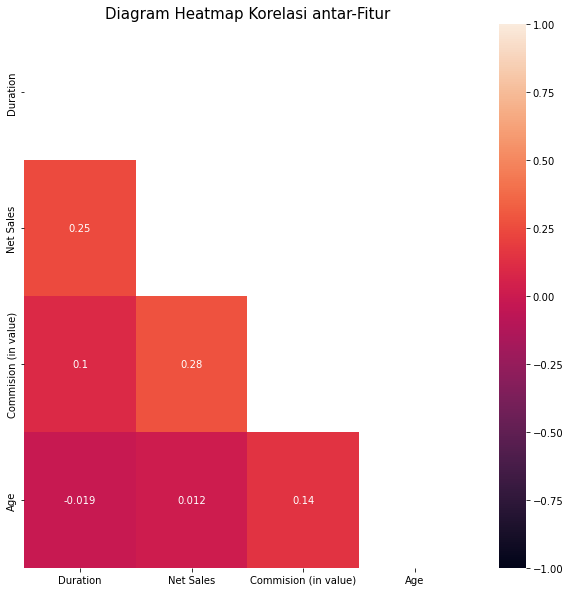

In [18]:
# Correlation Heatmap
corr_mat = travel[['Duration','Net Sales', 'Commision (in value)', 'Age']].corr('spearman')
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)]=True

plt.figure (figsize=(10,10))
plt.title ("Diagram Heatmap Korelasi antar-Fitur", fontsize=15)
sns.heatmap(corr_mat, annot = True, vmax=1, vmin=-1, mask=mask)

plt.show()

Ada beberapa variabel yang memiki tingkat signifikansi kecil yang bernilai positif :
* `Net Sales` dengan `Commision (in value)` yang dimana semakin besar nilai penjualan makan semakin tinggi komisi yang didapat 
* `Duration` dengan `Net Sales` yang dimana semakin lama seseorang melakukan perjalan juga akan semakin mahal harga asuransinya

### 2.4.2 Melihat Hubungan Antar Data Kategorikal

In [19]:
# Melihat Correlation setiap fitur data kategorik
print("Uji Chi Squared pada Fitur Kategorik\n")
kategori = ['Claim','Agency', 'Agency Type', 'Distribution Channel', 'Product Name','Destination' ]
test = []
for i in kategori:
    for j in kategori:
        if i is not j and {i,j} not in test:
            test.append({i,j})
            pval = chi2_contingency(pd.crosstab(travel[i], travel[j]))[1]
            
            if pval <= 0.05:
                print(f"{i:19} & {j:19} dependen  , pval = {round(pval, 5)}")
            else:
                print(f"{i:19} & {j:19} independen, pval = {round(pval, 5)}")

Uji Chi Squared pada Fitur Kategorik

Claim               & Agency              dependen  , pval = 0.0
Claim               & Agency Type         dependen  , pval = 0.0
Claim               & Distribution Channel independen, pval = 0.84526
Claim               & Product Name        dependen  , pval = 0.0
Claim               & Destination         dependen  , pval = 0.0
Agency              & Agency Type         dependen  , pval = 0.0
Agency              & Distribution Channel dependen  , pval = 0.0
Agency              & Product Name        dependen  , pval = 0.0
Agency              & Destination         dependen  , pval = 0.0
Agency Type         & Distribution Channel dependen  , pval = 0.0
Agency Type         & Product Name        dependen  , pval = 0.0
Agency Type         & Destination         dependen  , pval = 0.0
Distribution Channel & Product Name        dependen  , pval = 0.0
Distribution Channel & Destination         dependen  , pval = 0.0
Product Name        & Destination         d

In [123]:
travel['Distribution Channel'].groupby(travel['Claim']).count()

Claim
No     38649
Yes      673
Name: Distribution Channel, dtype: int64

* Terlihat bahwa semua variabel dependen terhadap Claim dan juga satu sama lain kecuali `Claim` dengan `Distribution Channel`   
* Setelah dilihat kembali ternyata propori target bernilai 1 pada kolom claim cukup banyak maka kita akan tetap memasukkan kolom `Distribution Channel` sebagai Feature

# 3. Modelling

## 3.1 Data Preparation 

Semua variabel akan digunakan sebagai Feature

In [124]:
x=travel.drop(columns = ['Claim'])
y=np.where(travel['Claim']=='Yes',1,0)

### 3.1.1 Data Preprocessing

Beberapa data yang masih bertipe kategorikal akan dilakukan Encoding agar bisa dimasukkan kedalam pemodelan

In [130]:
tf = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'),['Agency Type','Distribution Channel']),
    ('binary', ce.BinaryEncoder(),['Product Name', 'Destination','Agency'])
], remainder='passthrough')

### 3.1.2 Data Splitting

In [131]:
x_train, x_test, y_train, y_test = train_test_split (x, y,
                                                    stratify=y,
                                                    test_size = 0.3,
                                                    random_state= 2020)

## 3.2 Modelling 

In [132]:
# Menentukan model yang akan digunakan
logreg = LogisticRegression(random_state=2020)
tree = DecisionTreeClassifier(max_depth=5,random_state=2020)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(max_depth=5,random_state=2020)
xgb = XGBClassifier(max_depth=5,random_state=2020)

Saya Memilih 5 Model untuk Dilakukan Cross Validasi 
1. Logistic Regression 
2. Decision Tree
3. K-Nearest Neighbour
4. Random Forest
5. XGBoost

Saya menambahkan parameter yakni :
* Random state bernilai 2020 agar hasil pengacakan tidak berbeda.
* Max Depth bernilai 5 agar tidak terjadi overfit pada model yang memiliki base Decision Tree

In [133]:
# Melakukan Cross Validation terhadap model

# Metode Cross validasi
skfold = StratifiedKFold(n_splits=5)

# Model yang digunakan
models = [logreg, tree, knn, rf, xgb]
name = ['Logistic Regression', 'Decision Tree', 'KNN', 'Random Forest', 'XGBoost']

# Scorer yangn digunakan
scorer = {
    'Precision' : 'precision',
    'Recall' : 'recall',
    'F1' : 'f1',
}

### 3.2.1 Menentukan Model Benchmark

In [134]:
# precision
score_pr = []
mean_pr = []
std_pr = []

# recall
score_rc = []
mean_rc = []
std_rc = []

# f1 score
score_f1 = []
mean_f1 = []
std_f1 = []

for i in models :
    estimator = Pipeline ([
        ('preprocess', tf),
        ('model', i)
    ])
    
    model_precision = cross_val_score(estimator,
                                      x_train, y_train,
                                      cv = skfold,
                                      scoring = 'precision')
    score_pr.append (model_precision)
    mean_pr.append (model_precision.mean())
    std_pr.append (model_precision.std())
    
    model_recall = cross_val_score(estimator,
                                   x_train, y_train,
                                   cv = skfold,
                                   scoring = 'recall')
    score_rc.append (model_recall)
    mean_rc.append (model_recall.mean())
    std_rc.append (model_recall.std())
    
    model_f1 = cross_val_score(estimator,
                               x_train, y_train,
                               cv = skfold,
                               scoring = 'f1')
    score_f1.append (model_f1)
    mean_f1.append (model_f1.mean())
    std_f1.append (model_f1.std())

In [135]:
pd.DataFrame ({
    'Mean Precision' : mean_pr,
    'Std Precision' : std_pr,
    'Mean Recall' : mean_rc,
    'Std Recall': std_rc,
    'Mean F1' : mean_f1,
    'Std F1': std_f1
}, index = name)

,Mean Precision,Std Precision,Mean Recall,Std Recall,Mean F1,Std F1
Logistic Regression,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Decision Tree,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
KNN,0.150000,0.133333,0.006361,0.005194,0.012163,0.009932
Random Forest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGBoost,0.152222,0.154264,0.010594,0.009465,0.019731,0.017726


Dari Hasil Cross Validasi Tertinggi di dapat model KNN dan XGBoost memiliki nilai f1 tertinggim

In [136]:
# Test KNN with data test
estimator = Pipeline ([
        ('preprocess', tf),
        ('model', knn)
    ])
estimator.fit (x_train, y_train)
y_pred = estimator.predict (x_test)

print ('Precision ', precision_score(y_test, y_pred))
print ('Recall ', recall_score(y_test, y_pred))
print ('F1 Score', f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Precision  0.16666666666666666
Recall  0.0049504950495049506
F1 Score 0.009615384615384616
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11595
           1       0.17      0.00      0.01       202

    accuracy                           0.98     11797
   macro avg       0.57      0.50      0.50     11797
weighted avg       0.97      0.98      0.97     11797



In [137]:
# Test XGBoost with data test
estimator = Pipeline ([
        ('preprocess', tf),
        ('model', xgb)
    ])
estimator.fit (x_train, y_train)
y_pred = estimator.predict (x_test)

print ('Precision ', precision_score(y_test, y_pred))
print ('Recall ', recall_score(y_test, y_pred))
print ('F1 score ', f1_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Precision  0.3333333333333333
Recall  0.0049504950495049506
F1 score  0.00975609756097561
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11595
           1       0.33      0.00      0.01       202

    accuracy                           0.98     11797
   macro avg       0.66      0.50      0.50     11797
weighted avg       0.97      0.98      0.97     11797



### 3.2.1 Balancing Models
Dari hasil Cross validasi Tidak ada model yang bisa di ambil oleh karena itu kita akan mencoba untuk melakukan Resampling.

Jenis Resampling yang akan kita gunakan yaitu RandomOverSampling, RandomUnderSampling,SMOTE

In [138]:
rus = RandomUnderSampler(random_state=2020)
ros = RandomOverSampler(random_state=2020)
smote= SMOTE(random_state=2020)

In [139]:
models = [['logreg',logreg], ['knn',knn], ['tree',tree],['rf',rf],['xgb',xgb]]
resampling = [['Undersampling',rus], ['Oversampling',ros], ['smote', smote]]
model_names=[]
recall_scorer=[]
precision_scorer=[]
f1_scorer=[]

for i in models:
    for j in resampling:
        estimators= Pipeline([
            ('preproses', tf),
            ('resampling', j[1] ),
            ('model', i[1]),
        ]) 
        estimators.fit(x_train, y_train)
        y_pred2=estimators.predict(x_test)
        model_names.append(i[0]+" "+j[0])
        recall_scorer.append(recall_score(y_test,y_pred2))
        precision_scorer.append(precision_score(y_test,y_pred2))
        f1_scorer.append(f1_score(y_test,y_pred2))

In [140]:
pd.DataFrame({
    'Model': model_names,
    'Recall Score' : recall_scorer,
    'Precision Score' : precision_scorer,
    'F1 Score' : f1_scorer,
}).sort_values('F1 Score').reset_index(drop=True)

,Model,Recall Score,Precision Score,F1 Score
0,knn Undersampling,0.673267,0.031813,0.060755
1,xgb smote,0.059406,0.071429,0.064865
2,xgb Undersampling,0.663366,0.040829,0.076923
3,knn smote,0.371287,0.046182,0.082147
4,tree Undersampling,0.717822,0.043648,0.082293
5,tree smote,0.683168,0.044951,0.084352
6,logreg Undersampling,0.658416,0.046005,0.086001
7,logreg Oversampling,0.638614,0.048588,0.090305
8,knn Oversampling,0.163366,0.064327,0.092308
9,logreg smote,0.638614,0.050195,0.093074


Kita akan mengambil hasil resampling dari 2 model terbaik

In [141]:
# Kita akan mencoba KNN Under Sampling Pada Data Test
model_knn_under = Pipeline ([
    ('preprocess', tf),
    ('resampling',rus),
    ('model', knn)
    ])
model_knn_under.fit (x_train, y_train)
y_pred = model_knn_under.predict (x_test)

print ('Precision ', precision_score(y_test, y_pred))
print ('Recall ', recall_score(y_test, y_pred))
print ('F1 score ', f1_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Precision  0.03181286549707602
Recall  0.6732673267326733
F1 score  0.06075496984587893
              precision    recall  f1-score   support

           0       0.99      0.64      0.78     11595
           1       0.03      0.67      0.06       202

    accuracy                           0.64     11797
   macro avg       0.51      0.66      0.42     11797
weighted avg       0.97      0.64      0.77     11797



In [142]:
# Kita akan mencoba XGBoost SMOTE Pada Data Test
model_xgb_smote = Pipeline ([
    ('preprocess', tf),
    ('resampling',smote),
    ('model', xgb)
    ])
model_xgb_smote.fit (x_train, y_train)
y_pred = model_xgb_smote.predict (x_test)

print ('Precision ', precision_score(y_test, y_pred))
print ('Recall ', recall_score(y_test, y_pred))
print ('F1 score ', f1_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Precision  0.07142857142857142
Recall  0.0594059405940594
F1 score  0.06486486486486487
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     11595
           1       0.07      0.06      0.06       202

    accuracy                           0.97     11797
   macro avg       0.53      0.52      0.52     11797
weighted avg       0.97      0.97      0.97     11797



### 3.2.2 Tuning Models

#### KNN Under Sampling

In [143]:
model_knn_under.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehot', OneHotEncoder(drop='first'),
                                    ['Agency Type', 'Distribution Channel']),
                                   ('binary', BinaryEncoder(),
                                    ['Product Name', 'Destination', 'Agency'])])),
  ('resampling', RandomUnderSampler(random_state=2020)),
  ('model', KNeighborsClassifier())],
 'verbose': False,
 'preprocess': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehot', OneHotEncoder(drop='first'),
                                  ['Agency Type', 'Distribution Channel']),
                                 ('binary', BinaryEncoder(),
                                  ['Product Name', 'Destination', 'Agency'])]),
 'resampling': RandomUnderSampler(random_state=2020),
 'model': KNeighborsClassifier(),
 'preprocess__n_jobs': None,
 'preprocess__remainder': 'passth

In [144]:
hyperparam_space={'model__weights':['uniform','distance'],
                  'model__n_neighbors':[1,5,25,100],
                  'model__algorithm': ['auto','ball_tree','kd_tree','brute'],
                  'model__leaf_size': [30,60,90]
                 }

In [145]:
skfold = StratifiedKFold(n_splits=5)
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(model_knn_under,
                        param_grid = hyperparam_space,
                        cv = skfold,
                        scoring = 'f1',
                        n_jobs=-1)

In [146]:
grid_knn.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Agency '
                                                                          'Type',
                                                                          'Distribution '
                                                                          'Channel']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['Product '
                                                                          'Name',
                                                                          'Destination',
                                                                          'Agency'])])),
                                       ('resampling',
                                        RandomUnderSampler(random_state=2020)),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                              'brute'],
                         'model__leaf_size': [30, 60, 90],
                         'model__n_neighbors': [1, 5, 25, 100],
                         'model__weights': ['uniform', 'distance']},
             scoring='f1')

In [147]:
grid_knn.best_params_, grid_knn.best_score_

({'model__algorithm': 'auto',
  'model__leaf_size': 30,
  'model__n_neighbors': 100,
  'model__weights': 'distance'},
 0.07051068561206414)

In [172]:
model_knn_hyper = grid_knn.best_estimator_
model_knn_hyper.fit(x_train,y_train)
print(classification_report(y_test, model_knn_hyper.predict(x_test)))
print('f1 score :',f1_score(y_test,model_knn_hyper.predict(x_test)))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     11595
           1       0.04      0.57      0.07       202

    accuracy                           0.76     11797
   macro avg       0.52      0.67      0.47     11797
weighted avg       0.97      0.76      0.85     11797

f1 score : 0.0746941403734707


#### XGBoost Smote

In [149]:
model_xgb_smote.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehot', OneHotEncoder(drop='first'),
                                    ['Agency Type', 'Distribution Channel']),
                                   ('binary', BinaryEncoder(),
                                    ['Product Name', 'Destination', 'Agency'])])),
  ('resampling', SMOTE(random_state=2020)),
  ('model',
   XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                 colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
                 grow_policy='depthwise', importance_type=None,
                 interaction_constraints='', learning_rate=0.300000012,
                 max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
                 max_delta_step=0, max_depth=5, max_leav

In [150]:
hyperparam_space = [
    {'model__learning_rate' : [0.3], 'model__n_estimators':[100], 'model__max_depth':[3,4,5]}, 
    {'model__learning_rate' : [0.03], 'model__n_estimators':[300], 'model__max_depth':[3,4,5]}, 
    {'model__learning_rate' : [0.003], 'model__n_estimators':[3000], 'model__max_depth':[3,4,5]} 
]

In [151]:
skfold = StratifiedKFold(n_splits=5)
xgb = XGBClassifier(max_depth=5,random_state=2020)
grid_xgb = GridSearchCV(model_xgb_smote,
                        param_grid = hyperparam_space,
                        cv = skfold,
                        scoring = 'f1',
                        n_jobs=-1)

In [152]:
grid_xgb.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Agency '
                                                                          'Type',
                                                                          'Distribution '
                                                                          'Channel']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['Product '
                                                                          'Name',
                                                                          'Destination',
                                                                          'Agency'])])),
                                       ('resampling', SMOTE(random_...
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=2020, ...))]),
             n_jobs=-1,
             param_grid=[{'model__learning_rate': [0.3],
                          'model__max_depth': [3, 4, 5],
                          'model__n_estimators': [100]},
                         {'model__learning_rate': [0.03],
                          'model__max_depth': [3, 4, 5],
                          'model__n_estimators': [300]},
                         {'model__learning_rate': [0.003],
                          'model__max_depth': [3, 4, 5],
                          'model__n_estimators': [3000]}],
             scoring='f1')

In [153]:
grid_xgb.best_params_, grid_xgb.best_score_

({'model__learning_rate': 0.03,
  'model__max_depth': 3,
  'model__n_estimators': 300},
 0.1505086642504307)

In [173]:
model_xgb_hyper = grid_xgb.best_estimator_
model_xgb_hyper.fit(x_train,y_train)
print(classification_report(y_test, model_xgb_hyper.predict(x_test)))
print('f1 score :', f1_score(y_test, model_xgb_hyper.predict(x_test)))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     11595
           1       0.08      0.49      0.13       202

    accuracy                           0.89     11797
   macro avg       0.53      0.69      0.54     11797
weighted avg       0.97      0.89      0.93     11797

f1 score : 0.13306451612903225


## 3.3 Memilih Model Terbaik 

In [155]:
# Membandingkan Kedua Model Yang Dipilih Untuk Tuning
print('KNN Setelah Dilakukan Tuning')
model_knn_hyper = grid_knn.best_estimator_
model_knn_hyper.fit(x_train,y_train)
print(classification_report(y_test, model_knn_hyper.predict(x_test)))


print('XGBoost Setelah Dilakukan Tuning')
model_xgb_hyper = grid_xgb.best_estimator_
model_xgb_hyper.fit(x_train,y_train)
print(classification_report(y_test, model_xgb_hyper.predict(x_test)))

KNN Setelah Dilakukan Tuning
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     11595
           1       0.04      0.57      0.07       202

    accuracy                           0.76     11797
   macro avg       0.52      0.67      0.47     11797
weighted avg       0.97      0.76      0.85     11797

XGBoost Setelah Dilakukan Tuning
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     11595
           1       0.08      0.49      0.13       202

    accuracy                           0.89     11797
   macro avg       0.53      0.69      0.54     11797
weighted avg       0.97      0.89      0.93     11797



Dari sini terlihat bahwa hasil f1 score dari **XGBoost yang telah dilakukan tuning yang lebih** baik daripada KNN yang telah dilakukan tuning.

In [156]:
# Membandingkan XGBoost yang lebih baik Sebelum atau Sesudah Tuning
print('XGBoost Sebelum Dilakukan Tuning')
model_xgb_smote = Pipeline ([
    ('preprocess', tf),
    ('Resampling',smote),
    ('model', xgb)
    ])
model_xgb_smote.fit (x_train, y_train)
y_pred = model_xgb_smote.predict (x_test)
print(classification_report(y_test,y_pred))


print('XGBoost Setelah Dilakukan Tuning')
model_xgb_hyper = grid_xgb.best_estimator_
model_xgb_hyper.fit(x_train,y_train)
print(classification_report(y_test, model_xgb_hyper.predict(x_test)))

XGBoost Sebelum Dilakukan Tuning
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     11595
           1       0.07      0.06      0.06       202

    accuracy                           0.97     11797
   macro avg       0.53      0.52      0.52     11797
weighted avg       0.97      0.97      0.97     11797

XGBoost Setelah Dilakukan Tuning
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     11595
           1       0.08      0.49      0.13       202

    accuracy                           0.89     11797
   macro avg       0.53      0.69      0.54     11797
weighted avg       0.97      0.89      0.93     11797



setelah di lakukan hyperparameter tunning nilai evaluasi metrics dari model mengalami kenaikan walaupun tidak naik signifikan. maka dari itu, model yang **digunakan** untuk menjawab business problem ialah model **XGBoost random under sampling yang sudah di tunning.**

## 3.4 Feature Importance  
Kita ingin melihat fitur mana yang paling berpengaruh pada model prediksi kita

In [157]:
model_xgb_hyper[0].transformers_[0][1].get_feature_names_out()

array(['Agency Type_Travel Agency', 'Distribution Channel_Online'],
      dtype=object)

In [158]:
model_xgb_hyper[0].transformers_[1][1].get_feature_names()

['Product Name_0',
 'Product Name_1',
 'Product Name_2',
 'Product Name_3',
 'Product Name_4',
 'Destination_0',
 'Destination_1',
 'Destination_2',
 'Destination_3',
 'Destination_4',
 'Destination_5',
 'Destination_6',
 'Agency_0',
 'Agency_1',
 'Agency_2',
 'Agency_3',
 'Agency_4']

In [159]:
x.columns[model_xgb_hyper[0].transformers_[2][2]]

Index(['Duration', 'Net Sales', 'Commision (in value)', 'Age'], dtype='object')

In [160]:
features = list(model_xgb_hyper[0].transformers_[0][1].get_feature_names_out()) + model_xgb_hyper[0].transformers_[1][1].get_feature_names() + list(x.columns[model_xgb_hyper[0].transformers_[2][2]])

In [161]:
features

['Agency Type_Travel Agency',
 'Distribution Channel_Online',
 'Product Name_0',
 'Product Name_1',
 'Product Name_2',
 'Product Name_3',
 'Product Name_4',
 'Destination_0',
 'Destination_1',
 'Destination_2',
 'Destination_3',
 'Destination_4',
 'Destination_5',
 'Destination_6',
 'Agency_0',
 'Agency_1',
 'Agency_2',
 'Agency_3',
 'Agency_4',
 'Duration',
 'Net Sales',
 'Commision (in value)',
 'Age']

<AxesSubplot:>

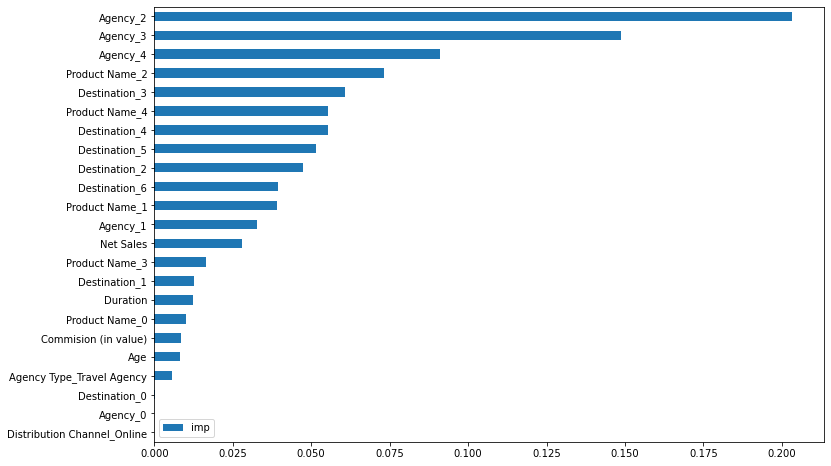

In [162]:
pd.DataFrame({'imp':model_xgb_hyper[2].feature_importances_}, index=features).sort_values('imp', ascending=True).plot(kind = 'barh', figsize=(12,8))

Terlihat bahwa features yang paling berpengaruh terhadap seorang customer akan melakukan claim adalah agency tempat ia membeli asuransi (dalam hal ini agensi ke 2). apabila running model terlalu berat salah satu opsi yang dapat dilakukan ialah menghapus feature yang tidak terlalu berpengaruh terhadap keputusan customer dalam melakukan claim.

# 4. Kesimpulan

## 4.1 Model Yang Dipilih

#### XGBoost SMOTE Setelah Hyperparameter Tuning

In [163]:
model_xgb_hyper = grid_xgb.best_estimator_
model_xgb_hyper.fit(x_train,y_train)
print(classification_report(y_test, model_xgb_hyper.predict(x_test)))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     11595
           1       0.08      0.49      0.13       202

    accuracy                           0.89     11797
   macro avg       0.53      0.69      0.54     11797
weighted avg       0.97      0.89      0.93     11797



didapatkan bahwa model yang memiliki evaluasi metrics terbaik ialah model xgboost yang telah dilakukan hyperparametertunning. xgboost sendiri ialah model yang dibuat dengan based decision tree. pada dasarnya model boosting sendiri pertama2 dia membuat pohon keputusan dari data training nya terlebih dahulu. dari pohon keputusan yang pertama akan dibangun pohon keputusan kedua yang telah dilakukan koreksi pada hasil prediksinya dengan cara menambahkan bobot pada data yang salah. proses ini akan dilakukan secara terus menerus sampai jumlah yang diperintahkan. hasil prediksi dari tiap pohon keputusan pada akhirnya akan dilakukan majority voting untuk menentukan nilai final prediksi.  perbedaan xgboost dengan boosting lainnya, xgboost menambahkan beberapa proses tambahan sehingga lebih powerful. Proses tersebut adalah pemangkasan, newton boosting, dan parameter pengacakan ekstra.

## 4.2 Confussion Matrix

dari hasil evaluasi metrics model nanti bisa didapatkan confussion metrics. Confession metrics memberikan rincian hasil prediksi dan jenis kesalahan. Setiap sel dalam matriks mewakili kombinasi contoh respons yang diprediksi dan respons aktual. 

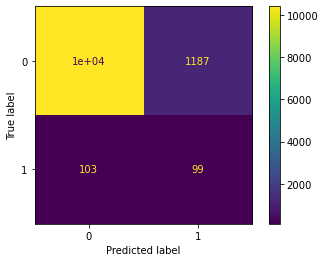

In [164]:
plot_confusion_matrix(model_xgb_hyper, x_test, y_test)

## 4.3 Cost Evaluation

### 4.3.1 Tanpa Model Machine Learning
Dari 1000 customer, apabila tanpa menggunakan model machine learning, perusahaan harus mengalokasikan dana tidak bergerak untuk setiap customer karena kita tidak bisa memprediksi apakah mereka akan melakukan claim atau tidak. Bila 1 customer dapat melakukan claim tanggungan sekitar 1.300 SGD paling sedikit (berdasarkan sumber, setelah dilakukan konversi mata uang https://www.asuransiperjalananonline.com/allianz-travelpro/) 

Perhitungan :   
* 1 Customer -> harus disiapkan dana sekitar 1.300 SGD
* Asumsikan kita memiliki 1000 customer
* Apabila kita mengasumsikan semua customer melakukan claim -> 1000 x 1.300 SGD = 1.300.000 SGD

### 4.3.2 Dengan Model Machine Learning
apabila menggunakan model machine learning, kita memprediksi hanya sebanyak 8% orang yang akan benar-benar melakukan claim.

Perhitungan :   
* 1 Customer -> harus disiapkan dana sekitar 1.300 SGD
* Asumsikan kita memiliki 1000 customer, 8% yang hanya claim : 1000 x 8% = 80 
* Apabila kita bisa memprediksi hanya 80 orang yang akan melakukan claim -> 80 x 1.300 SGD= 104.000 SGD

### 4.3.3 Cost Evaluation Conclusion
Tanpa menggunakan model machine learning perusahaan harus menyiapkan dana tidak bergerak sebesar 1.300.000 SGD untuk seluruh customer, sedangkan jika kita menggunakan model yang terpilih perusahaan hanya perlu mempersiapkan 104.000 SGD, perusahaan dapat mengalokasikan dana sekitar 1.196.000 SGD tersebut untuk di putarkan dalam membangun ataupun mengembang sektor bisnis perusahaan lainnya.

# 5. Rekomendasi 

Kita dapat mengembangkan project dan model yang lebih baik dengan melakukan :

1. Membuat catatan yang lebih lengkap agar seluruh fitur pada dataset dapat dipergunakan terutama pada kolom `Gender` 
2. Dapat menambahkan kolom baru yang lebih relevan terhadap apakah customer akan melakukan claim atau tidak, seperti kolom `Riwayat Penyakit` (untuk mengetahui lebih jelas karakteristik dari customer), kolom `Melakukan perjalan sendiri atau kelompok`, etc.      
3. Dapat mencoba untuk mengeksplore data lebih jauh lagi.     
4. Dapat menambahkan matrix evaluasi lainnya seperti fbeta - score juga sebagai pembanding.  
5. Dapat mencoba algoritma machine learning yang lain, serta dapat melakukan metode resampling lain untuk diterapkan pada algoritma machine learning yang dipilih.     
6. Dapat melakukan hyperparameter tuning kembali untuk mendapatkan performa yang lebih baik lagi.   
7. Melakukan Analisa  yang jauh lebih dalam terhadap model yang lain lagi.

### Save Model

In [178]:
model_save=model_xgb_hyper.fit(x,y)
model_save

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Agency Type',
                                                   'Distribution Channel']),
                                                 ('binary', BinaryEncoder(),
                                                  ['Product Name',
                                                   'Destination',
                                                   'Agency'])])),
                ('resampling', SMOTE(random_state=2020)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.03,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=3, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=300, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=2020, ...))])

In [179]:
# Save Model
pickle.dump(model_save, open('model_prediction_pickle.sav','wb'))